# Load checkpoints and data

In [1]:
import pandas as pd
import numpy as np
import torch
from generative_model.bgm import BGM
from config_cade_nootbook import get_config_pend
from preprocess.preprocess_img import make_dataloader
from attacker_cade import CADELatent
from torchvision.transforms import functional as F

import models.resnet as resnet
import models.vgg as vgg

def denorm(x):
    out = (x + 1) / 2
    return out.clamp_(0, 1)


torch.backends.cudnn.deterministic=True

# load args and ckpts
args = get_config_pend()
print(args)
device = torch.device('cuda')

substitute = args.substitute
epsilon = args.epsilon
type_loss = args.type_loss
num_steps = args.num_steps
step_size = args.step_size
path_ckpt_generative = args.path_ckpt_generative
path_ckpt_resnet50 = args.path_ckpt_resnet50
path_ckpt_resnet50_pgd = args.path_ckpt_resnet50_pgd
path_ckpt_vgg16 = args.path_ckpt_vgg16
path_ckpt_vgg16_pgd = args.path_ckpt_vgg16_pgd

ckpt_generative = torch.load(path_ckpt_generative, map_location=device)  # load the ckpt of the pretrained causal generative model
ckpt_resnet50 = torch.load(path_ckpt_resnet50, map_location=device)
ckpt_resnet50_pgd = torch.load(path_ckpt_resnet50_pgd, map_location=device)
ckpt_vgg16 = torch.load(path_ckpt_vgg16, map_location=device)
ckpt_vgg16_pgd = torch.load(path_ckpt_vgg16_pgd, map_location=device)

# causal graph for Pendulum
A = torch.zeros((4, 4))
A[0, 2:4] = 1
A[1, 2:4] = 1
num_classes = 50
target_label_idx = 0  # the index of label pendulum_angle


print('Build models...')
model = BGM(latent_dim=6,
            conv_dim=32,
            image_size=64,
            enc_dist='gaussian',
            enc_arch='resnet',
            enc_fc_size=1024,
            enc_noise_dim=128,
            dec_dist='implicit',
            prior='nlrscm',
            num_label=4,
            A=A)
model.load_state_dict(ckpt_generative['model'])
model.eval()
model.to(device)

model_resnet50 = resnet.ResNet50(num_classes=num_classes).to(device)
model_resnet50.load_state_dict(ckpt_resnet50)
model_resnet50_pgd = resnet.ResNet50(num_classes=num_classes).to(device)
model_resnet50_pgd.load_state_dict(ckpt_resnet50_pgd)
model_vgg16 = vgg.VGG('VGG16', num_classes=num_classes).to(device)
model_vgg16.load_state_dict(ckpt_vgg16)
model_vgg16_pgd = vgg.VGG('VGG16', num_classes=num_classes).to(device)
model_vgg16_pgd.load_state_dict(ckpt_vgg16_pgd)

model_resnet50.eval()
model_resnet50_pgd.eval()
model_vgg16.eval()
model_vgg16_pgd.eval()

print('Model loaded')

Namespace(image_size=64, dataset='pendulum', substitute='resnet50', data_dir='data/pendulum/', batch_size=32, num_steps=20, epsilon=0.3, step_size=0.4, type_loss='pendulum', path_ckpt_generative='ckpt/pendulum/pendulum_bgm.pt', path_ckpt_resnet50='ckpt/pendulum/pendulum_resnet50.pt', path_ckpt_resnet50_pgd='ckpt/pendulum/pendulum_defense_resnet50_pgd.pt', path_ckpt_vgg16='ckpt/pendulum/pendulum_vgg16.pt', path_ckpt_vgg16_pgd='ckpt/pendulum/pendulum_defense_vgg16_pgd.pt')
Build models...
2048
2048
Model loaded


In [2]:
data_loader = make_dataloader(args)
size_dataset = len(data_loader.dataset)

[ 0. 50.  3.  3.]
[49. 98. 13. 13.]
mean: [24.51923077 74.03846154  7.04967949  8.15544872]
std [14.4090744  14.40169355  2.7448845   2.08009549]


In [3]:
for batch_id, (x, label) in enumerate(data_loader):
    if batch_id == 15: break
x = x.to(device)
label = label[:, target_label_idx].long().to(device)

In [4]:
# attack on z_1, z_2, z_3, z_{1,2,3}

if substitute == 'resnet50':
    model_white = model_resnet50
elif substitute == 'vgg16':
    model_white = model_vgg16
model_white.eval()

l_attacking_nodes = [[1], [2], [3], [1, 2, 3]] # z1 (light_angle), z2 (shadow_length), z3 (shadow_position), z1:3
l_causal = [True, False, False, False]  # since variables z_2 and z_3 both have no descendants in z, thus setting False to avoid extra computations
ranges = [[6.8932], [13.4833], [6.9335], [6.8932, 13.4833, 6.9335]]  # the range of the latent z

In [5]:
imgs_to_show = []
diff_to_show = []
l_is_success = []


for mode in range(len(l_attacking_nodes)):
    attacker = CADELatent(model, attacking_nodes=l_attacking_nodes[mode], substitute=model_white, device=device)
    num_success_resnet50 = 0
    num_success_resnet50_pgd = 0
    num_success_vgg16 = 0
    num_success_vgg16_pgd = 0

    print("Attacking variables: ", l_attacking_nodes[mode])
    print("-------------------------------------------")
    x_cade = attacker.attack_whitebox(x, label, lr=step_size, epochs=num_steps, type_loss=type_loss, epsilon=epsilon * torch.FloatTensor(ranges[mode]).to(device), causal_layer=l_causal[mode])

    pred_resnet50 = torch.argmax(model_resnet50(x_cade), dim=1)  # transfer to resnet50
    pred_resnet50_pgd = torch.argmax(model_resnet50_pgd(x_cade), dim=1)  # transfer to resnet50 pgd defense
    pred_vgg16 = torch.argmax(model_vgg16(x_cade), dim=1)  # transfer to vgg16
    pred_vgg16_pgd = torch.argmax(model_vgg16_pgd(x_cade), dim=1)  # transfer to vgg16 pgd defense

    is_success_resnet50 = (torch.abs(pred_resnet50 - label) > 0).float()
    is_success_resnet50_pgd = (torch.abs(pred_resnet50_pgd - label) > 0).float()
    is_success_vgg16 = (torch.abs(pred_vgg16 - label) > 0).float()
    is_success_vgg16_pgd = (torch.abs(pred_vgg16_pgd - label) > 0).float()
    print(is_success_resnet50)

    num_success_resnet50_batch_i = torch.sum(is_success_resnet50)  # number of success attacks in batch i
    num_success_resnet50_pgd_batch_i = torch.sum(is_success_resnet50_pgd)
    num_success_vgg16_batch_i = torch.sum(is_success_vgg16)
    num_success_vgg16_pgd_batch_i = torch.sum(is_success_vgg16_pgd)

    print("z_{} attacked!".format(l_attacking_nodes[mode]))
    print("resnet50, asr: {}".format(num_success_resnet50_batch_i / (label.shape[0])))
    print("resnet50 pgd defense, asr: {}".format(num_success_resnet50_pgd_batch_i / (label.shape[0])))
    print("vgg16, asr: {}".format(num_success_vgg16_batch_i / (label.shape[0])))
    print("vgg16 pgd defense, asr: {}".format(num_success_vgg16_pgd_batch_i / (label.shape[0])))
    print("-------------------------------------------")


    img_idx = 8
    imgs_to_show.append(F.to_pil_image(x_cade[img_idx]))
    diff_to_show.append(F.to_pil_image(denorm(x_cade[img_idx]-x[img_idx])))
    l_is_success.append(is_success_resnet50[img_idx])
    

Attacking variables:  [1]
-------------------------------------------
epoch: 0, loss_pred: -3.6073896884918213
epoch: 1, loss_pred: -3.6406452655792236
epoch: 2, loss_pred: -4.237843990325928
epoch: 3, loss_pred: -4.556094646453857
epoch: 4, loss_pred: -4.764795303344727
epoch: 5, loss_pred: -5.004439830780029
epoch: 6, loss_pred: -5.42932653427124
epoch: 7, loss_pred: -5.499385356903076
epoch: 8, loss_pred: -5.427648544311523
epoch: 9, loss_pred: -5.4752516746521
epoch: 10, loss_pred: -5.549370765686035
epoch: 11, loss_pred: -5.484406471252441
epoch: 12, loss_pred: -5.588921070098877
epoch: 13, loss_pred: -5.58353328704834
epoch: 14, loss_pred: -5.560956954956055
epoch: 15, loss_pred: -5.59445333480835
epoch: 16, loss_pred: -5.541194915771484
epoch: 17, loss_pred: -5.42313814163208
epoch: 18, loss_pred: -5.638919353485107
epoch: 19, loss_pred: -5.583292484283447
tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 

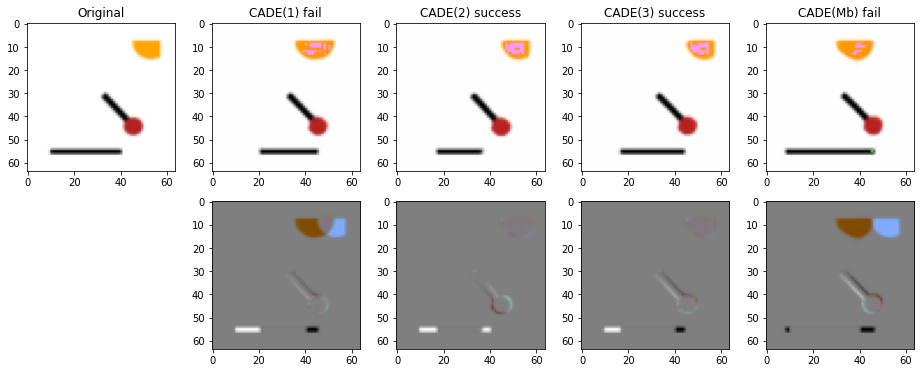

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

flags = ['fail', 'success']
fig = plt.figure(figsize=(16, 6))
plt.subplot(251)
plt.title("Original")
plt.imshow(F.to_pil_image(x[img_idx]))

plt.subplot(252)
plt.title("CADE(1) {}".format(flags[int(l_is_success[0])]))
plt.imshow(imgs_to_show[0], norm=Normalize(0, 1))

plt.subplot(253)
plt.title("CADE(2) {}".format(flags[int(l_is_success[1])]))
plt.imshow(imgs_to_show[1])

plt.subplot(254)
plt.title("CADE(3) {}".format(flags[int(l_is_success[2])]))
plt.imshow(imgs_to_show[2])

plt.subplot(255)
plt.title("CADE(Mb) {}".format(flags[int(l_is_success[0])]))
plt.imshow(imgs_to_show[3])

plt.subplot(257)
plt.imshow(diff_to_show[0])

plt.subplot(258)
plt.imshow((diff_to_show[1]))

plt.subplot(259)
plt.imshow(diff_to_show[2])

plt.subplot(2,5,10)
plt.imshow(diff_to_show[3])